# SBM test with density adjustment

In [1]:

import datetime
import time
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspologic.simulations import sbm
from myst_nb import glue as default_glue
from pkg.data import load_network_palette, load_node_palette, load_unmatched
from pkg.io import savefig
from pkg.io.io import FIG_PATH, OUT_PATH
from pkg.perturb import remove_edges
from pkg.plot import heatmap_grouped, networkplot_simple, plot_pvalues, set_theme
from pkg.stats import stochastic_block_test
from tqdm import tqdm

DISPLAY_FIGS = False

FILENAME = "adjusted_sbm_unmatched_test"


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, prefix="fig")

    if not DISPLAY_FIGS:
        plt.close()


def glue(name, var, prefix=None):
    savename = f"{FILENAME}-{name}"
    if prefix is not None:
        savename = prefix + ":" + savename
    default_glue(savename, var, display=False)


t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

network_palette, NETWORK_KEY = load_network_palette()
node_palette, NODE_KEY = load_node_palette()
neutral_color = sns.color_palette("Set2")[2]

GROUP_KEY = "simple_group"

left_adj, left_nodes = load_unmatched(side="left")
right_adj, right_nodes = load_unmatched(side="right")

left_labels = left_nodes[GROUP_KEY].values
right_labels = right_nodes[GROUP_KEY].values

In [2]:

np.random.seed(888888)
ns = [5, 6, 7]
B = np.array([[0.8, 0.2, 0.05], [0.05, 0.9, 0.2], [0.05, 0.05, 0.7]])
A1, labels = sbm(ns, B, directed=True, loops=False, return_labels=True)

node_data = pd.DataFrame(index=np.arange(A1.shape[0]))
node_data["labels"] = labels + 1
palette = dict(zip(np.unique(labels) + 1, sns.color_palette("Set2")[3:]))


fig, axs = plt.subplots(
    1, 4, figsize=(13, 4), gridspec_kw=dict(width_ratios=[1, 0.5, 0.5, 1])
)
ax = axs[0]
node_data = networkplot_simple(A1, node_data, palette=palette, ax=ax, group=True)

n_select = 10
row_inds, col_inds = np.nonzero(A1)
np.random.seed(8888)
choice_inds = np.random.choice(len(row_inds), size=n_select)
for i in choice_inds:
    source_node = row_inds[i]
    target_node = col_inds[i]
    x1, y1 = node_data.loc[source_node, ["x", "y"]]
    x2, y2 = node_data.loc[target_node, ["x", "y"]]
    x = (x1 + x2) / 2
    y = (y1 + y2) / 2
    ax.text(
        x,
        y,
        "x",
        va="center",
        ha="center",
        color="darkred",
        fontsize="medium",
        zorder=2,
    )


ax.set_title("Randomly subsample\nedges", fontsize="medium")
ax.set_ylabel(
    "Right",
    color=network_palette["Right"],
    size="large",
    rotation=0,
    ha="right",
    labelpad=10,
)


ax = axs[1]
_, _, misc = stochastic_block_test(A1, A1, node_data["labels"], node_data["labels"])
Bhat1 = misc["probabilities1"].values
top_ax = heatmap_grouped(Bhat1, [1, 2, 3], palette=palette, ax=ax)
top_ax.set_title("Adjust connection probabilities", fontsize="medium", x=1.2, y=6)


ax = axs[2]
Bhat1 = misc["probabilities1"].values
top_ax = heatmap_grouped(0.6 * Bhat1, [1, 2, 3], palette=palette, ax=ax)

ax.annotate(
    "",
    xy=(0, 1.5),
    xytext=(-1, 1.5),
    arrowprops=dict(
        arrowstyle="simple",
        shrinkB=9,
        facecolor="black",
    ),
    zorder=1,
)

ax = axs[3]
ax.set_title("Rerun SBM testing")
ax.axis("off")

fig.set_facecolor("w")

gluefig("adjusted_methods_explain", fig)

In [3]:
n_edges_left = np.count_nonzero(left_adj)
n_edges_right = np.count_nonzero(right_adj)
n_left = left_adj.shape[0]
n_right = right_adj.shape[0]
density_left = n_edges_left / (n_left ** 2)
density_right = n_edges_right / (n_right ** 2)

n_remove = int((density_right - density_left) * (n_right ** 2))

glue("density_left", density_left)
glue("density_right", density_right)
glue("n_remove", n_remove)

In [4]:

rows = []
n_resamples = 500
glue("n_resamples", n_resamples)
RERUN_SIM = False

from pkg.io import OUT_PATH

OUT_PATH = OUT_PATH / FILENAME
# OUT_PATH = Path(f"bilateral-connectome/results/outputs/{FILENAME}")

if RERUN_SIM:
    for i in tqdm(range(n_resamples)):
        subsampled_right_adj = remove_edges(
            right_adj, effect_size=n_remove, random_seed=rng
        )
        for combine_method in ["tippett"]:
            stat, pvalue, misc = stochastic_block_test(
                left_adj,
                subsampled_right_adj,
                labels1=left_labels,
                labels2=right_labels,
                method="fisher",
                combine_method=combine_method,
            )
            rows.append(
                {
                    "stat": stat,
                    "pvalue": pvalue,
                    "misc": misc,
                    "resample": i,
                    "combine_method": combine_method,
                }
            )
    resample_results = pd.DataFrame(rows)
    resample_results.to_csv(OUT_PATH / "resample_results.csv")
else:
    resample_results = pd.read_csv(OUT_PATH / "resample_results.csv", index_col=0)

In [5]:
stat, pvalue, misc = stochastic_block_test(
    left_adj,
    right_adj,
    labels1=left_labels,
    labels2=right_labels,
    method="fisher",
    density_adjustment=True,
    combine_method="tippett",
)
glue("corrected_pvalue", pvalue)
print(pvalue)
print(f"{pvalue:.2g}")

0.001638721378516114
0.0016


In [6]:

set_theme(font_scale=1.25)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(
    data=resample_results[resample_results["combine_method"] == "tippett"],
    x="pvalue",
    ax=ax,
    color=neutral_color,
    # bins=30,
    kde=True,
    # kde_kws=dict(clip=[0, 1]),
    log_scale=True,
    stat="density",
)
ax.set(xlabel="p-value", ylabel="", yticks=[])
ax.spines["left"].set_visible(False)
ax.axvline(0.05, linestyle=":", color="black")
ylim = ax.get_ylim()
ax.text(0.06, ylim[1] * 0.9, r"$\alpha = 0.05$")

median_resample_pvalue = np.median(resample_results["pvalue"])

colors = sns.color_palette("Set2")


color = colors[3]
ax.axvline(median_resample_pvalue, color=color, linewidth=3)
# ax.text(
#     median_resample_pvalue - 0.0025,
#     ylim[1] * 0.9,
#     f"Median = {median_resample_pvalue:0.2g}",
#     ha="right",
#     color=color,
# )
ax.text(
    median_resample_pvalue - 0.0025,
    ylim[1] * 0.9,
    f"Median = {median_resample_pvalue:0.2g}",
    color=color,
    ha="right",
)

color = colors[4]
ax.axvline(pvalue, 0, 0.5, color=color, linewidth=3)
ax.text(
    pvalue - 0.0002,
    ylim[1] * 0.43,
    f"Analytic = {pvalue:0.2g}",
    ha="right",
    color=color,
)

gluefig("resampled_pvalues_distribution", fig)

In [7]:

fig, axs = plot_pvalues(misc)

gluefig("sbm_uncorrected_pvalues", fig)

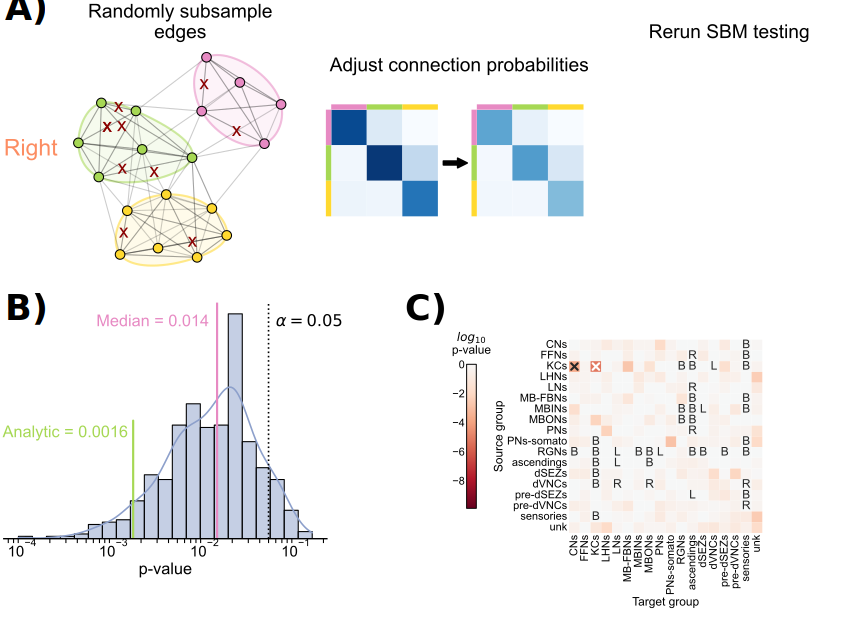

In [8]:
from pkg.io import FIG_PATH
from svgutils.compose import SVG, Figure, Panel, Text

total_width = 1000
total_height = 700

FIG_PATH = FIG_PATH / FILENAME

fontsize = 35

sbm_methods_explain_svg = SVG(FIG_PATH / "adjusted_methods_explain.svg")
sbm_methods_explain_svg_scaler = 1 / sbm_methods_explain_svg.height * total_height / 2
sbm_methods_explain_svg = sbm_methods_explain_svg.scale(sbm_methods_explain_svg_scaler)

sbm_methods_explain = Panel(
    sbm_methods_explain_svg,
    Text("A)", 5, 20, size=fontsize, weight="bold"),
)


resampled_pvalues_distribution = SVG(FIG_PATH / "resampled_pvalues_distribution.svg")
resampled_pvalues_distribution.scale(
    1 / resampled_pvalues_distribution.height * total_height / 2
)

resampled_pvalues_distribution = Panel(
    resampled_pvalues_distribution,
    Text("B)", 5, 20, size=fontsize, weight="bold"),
).move(0, 300)


pvalues = SVG(FIG_PATH / "sbm_uncorrected_pvalues.svg")
pvalues.scale(1 / pvalues.height * total_height / 2)

pvalues = Panel(
    pvalues.move(50, 30),
    Text("C)", 5, 20, size=fontsize, weight="bold"),
).move(400, 300)

fig = Figure(850, 625, sbm_methods_explain, resampled_pvalues_distribution, pvalues)
fig.save(FIG_PATH / "adjusted_sbm_composite.svg")
fig

In [9]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)